In [1]:
using Fretem, Potential, PyPlot, Printf

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 10 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{eq}(x)$ for simulation

In [54]:
k_ref = 1 # unit: kcal/mol/angstrom^2
Vref = harmonic_well_k_mean(xref, k_ref, xavg)
rho_eq = get_rhoeq(Vref, w0);

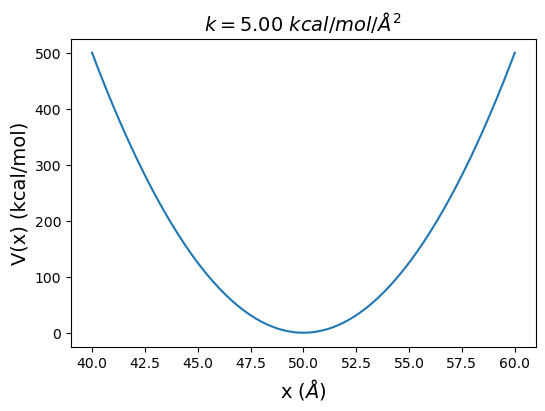

In [4]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,4))

ax.plot(xref, Vref)
ax.set_xlabel("x (\$ \\AA \$)", fontsize=lbfz)
ax.set_ylabel("V(x) (kcal/mol)", fontsize=lbfz)
title = @sprintf "\$ k=%.2f ~kcal/mol/\\AA^2 \$" k_ref
ax.set_title(title, fontsize=lbfz)

plt.show()

### Part 3: Langenvin dynamics simulations

In [58]:
# physical parameters
save_freq = 1e-10 # unit: s, Save trajectory per 100 ps
total_times = 1e-5 # unit: s, totol simulate 10 us, 1e-5
dt = 1e-12 # unit: s  # Integration Times 1ps
#kbT = 1
D = 2.5e7; # Diffusion coefficient, unit: angstrom^2 s-1
tau = Int(total_times / save_freq)  # Number of photons
n_interval = Int(save_freq / dt);

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 100000 data points.


In [63]:
# Initialize Variables
y_record = zeros(tau+1, 1)  # In HMM, observing variables Y(t)
t_record = zeros(tau+1, 1)

ypos = xavg # Initial Position, from mean position
t = 0

# Simulation Start
for tau_id = 1:tau
    y_record[tau_id] = ypos
    t_record[tau_id] = t
    for i = 1:n_interval
        F = force_harmonic_well_k_mean(ypos, k_ref, xavg)
        ypos = ypos + D*dt*F +  (dt*2*D)^(1/2) * randn()
        t += dt   
    end
end
y_record[tau+1] = ypos
t_record[tau+1] = t;

9.999999999154996e-6

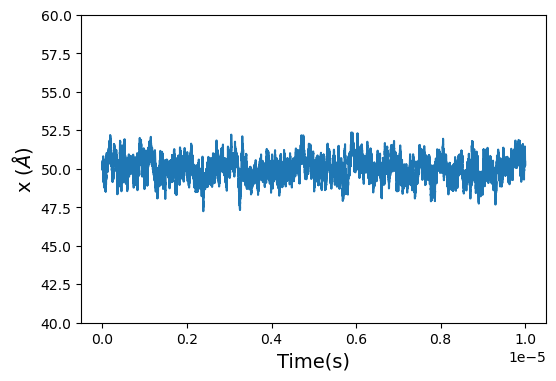

In [62]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (\$ \\AA \$)", fontsize=lbfz)
ax.set_xlabel("Time(s)", fontsize=lbfz)
#title = @sprintf "\$ k=%.2f ~kcal/mol/\\AA^2 \$" k_ref
#ax.set_title(title, fontsize=lbfz)
ax.set_ylim(40,60)

plt.show()

### Function

In [15]:
function harmonic_well_k_mean(xref, k, xmean)
    V = k * (xref .- xmean) .^ 2
    return V
end

ErrorException: error in method definition: function Potential.harmonic_well_k_mean must be explicitly imported to be extended

In [17]:
function force_harmonic_well_k_mean(x, k, xmean)
    F = 2 * k * (x - xmean)
    F = -F
    return F
end

force_harmonic_well_k_mean (generic function with 1 method)